In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from kaggler.model import AutoLGB
from imblearn.over_sampling import SMOTE

In [199]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [200]:
train.drop(['FLAG_MOBIL'], axis=1, inplace=True)
train.fillna('BaekSu', inplace=True) 

test.drop(['FLAG_MOBIL'], axis=1, inplace=True)
test.fillna('BaekSu', inplace=True)


In [201]:
train = train[train['family_size'] <= 7]

In [202]:
train.set_index('index', inplace=True)
train = train.reset_index(drop=True)

In [203]:
train.loc[(train.income_type=='Student'), 'income_type'] = 'State servant'
test.loc[(test.income_type=='Student'), 'income_type'] = 'State servant'

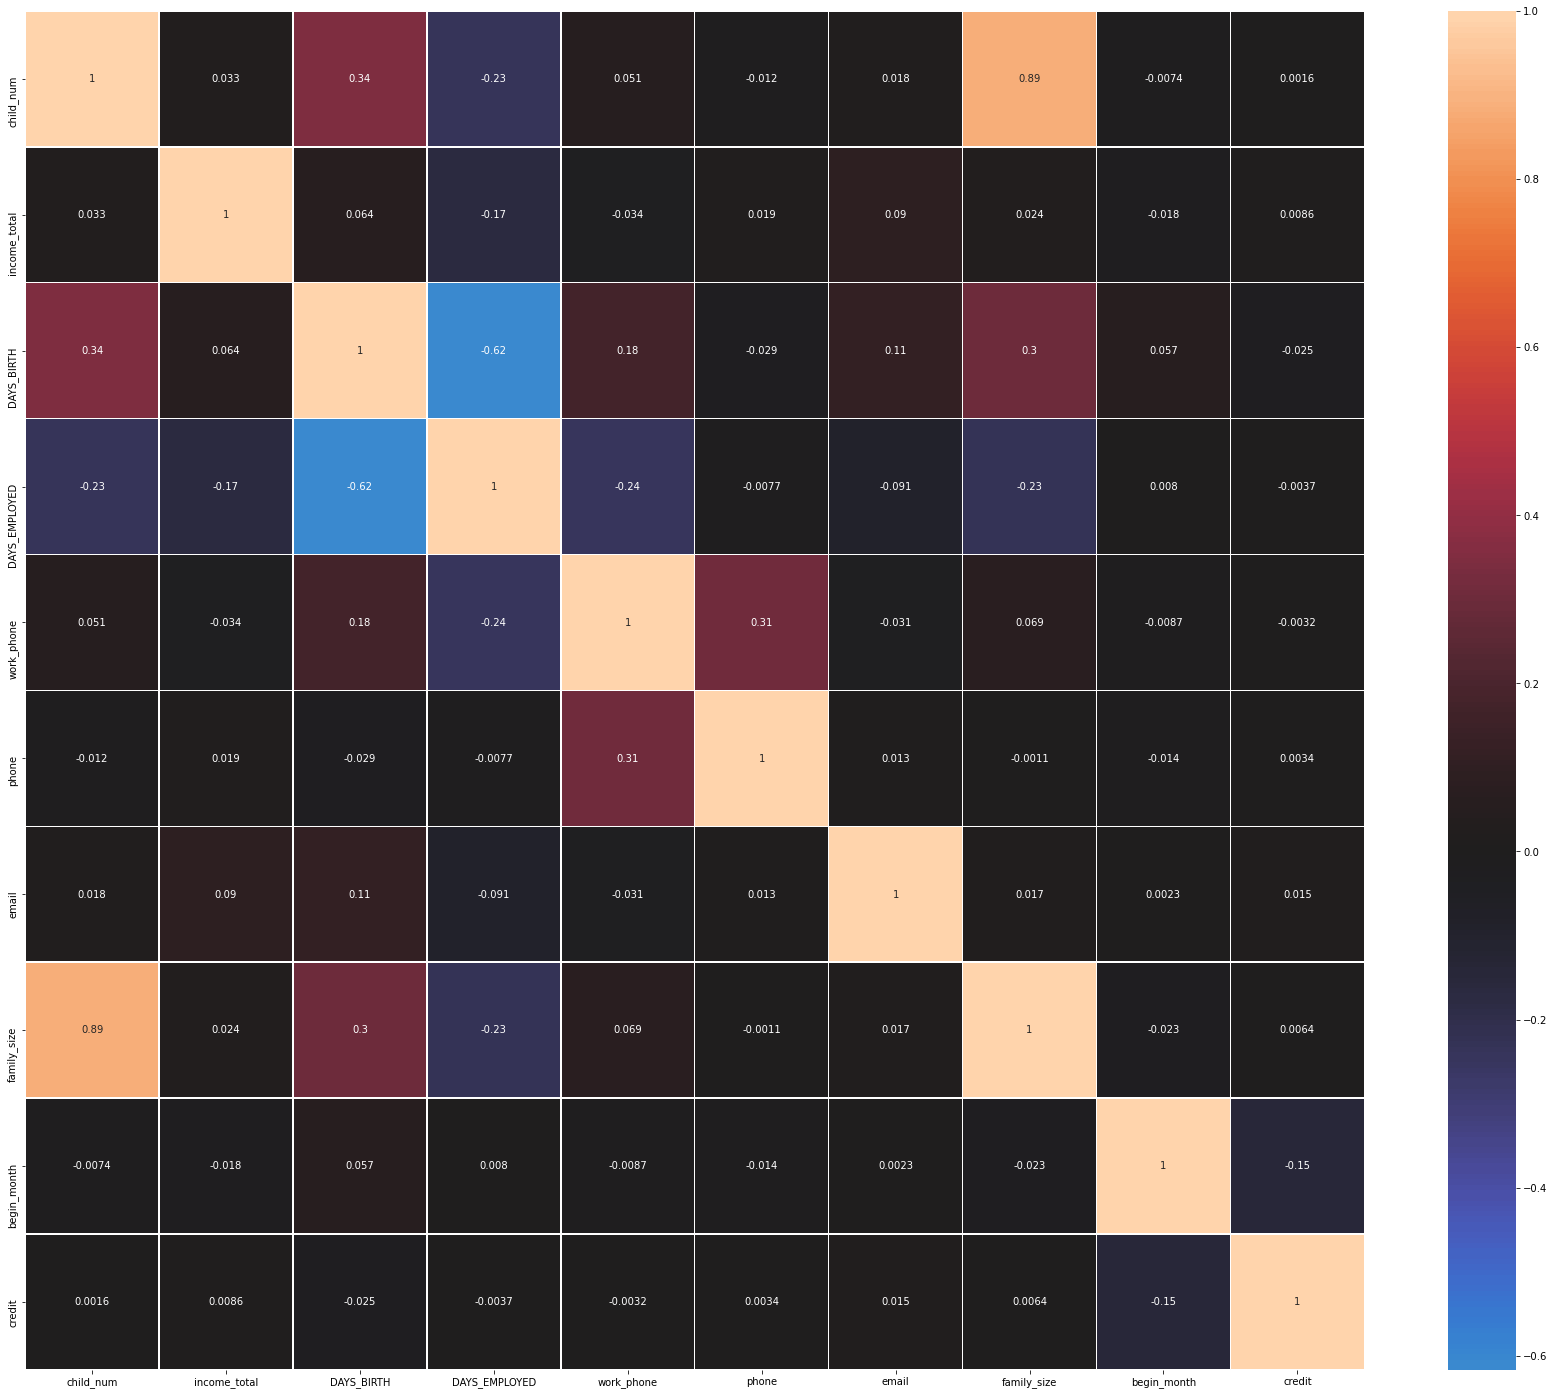

In [205]:
train_corr = train.corr()
ax = plt.subplots(figsize=(30, 25))
ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

In [206]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

total_feats = numerical_feats + categorical_feats

Number of Numerical features:  9
Number of Categorical features:  8


In [207]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,BaekSu,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,Core staff,4.0,-2.0,1.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,0,0,0,BaekSu,2.0,-47.0,2.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,Core staff,2.0,-25.0,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,0,0,0,Laborers,1.0,-59.0,2.0


### ID생성 / 중복컬럼 제거

In [208]:
# train['ID'] = \
# train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
# train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
# train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
# train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
# train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
# train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
# train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
# train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

# test['ID'] = \
# test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
# test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
# test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
# test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
# test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
# test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
# test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
# test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [209]:
# train = train.sort_values(by=['begin_month'], axis=0)
# test = test.sort_values(by=['begin_month'], axis=0)

In [210]:
train

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,BaekSu,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,0,0,0,Core staff,4.0,-2.0,1.0
26447,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,0,0,0,BaekSu,2.0,-47.0,2.0
26448,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,0,0,0,Core staff,2.0,-25.0,2.0
26449,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,0,0,0,Laborers,1.0,-59.0,2.0


In [211]:
#train.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)
#test.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)

In [212]:
#train.drop(['ID'], axis=1, inplace=True)
#test.drop(['ID'], axis=1, inplace=True)

In [213]:
#new_data=pd.DataFrame(train.groupby(["ID"])["begin_month"].agg(min))
#new_data

## LabelEncoding, Scaling

In [214]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=-train[feat]  
    test[feat]=-test[feat]    


In [215]:
for feat in categorical_feats:
    encoder = LabelEncoder()
    train[feat] = encoder.fit_transform(train[feat])
    test[feat] = encoder.transform(test[feat])

In [216]:
for col in ['family_size', 'child_num']:
    train[col] = np.log2(1 + train[col])
    test[col] = np.log2(1 + test[col])

# feats = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

# scaler = MinMaxScaler()
# train[['DAYS_EMPLOYED']] = scaler.fit_transform(train[['DAYS_EMPLOYED']])
# test[['DAYS_EMPLOYED']] = scaler.transform(test[['DAYS_EMPLOYED']])


## Modeling

In [217]:
n_est = 1000
seed = 42
n_fold = 5
n_class = 3

rf_params = {
    'max_depth': 15,
    'min_samples_leaf': 8,
    'random_state': seed
}

lgb_params = {
    'metric': 'multi_logloss',
    'n_estimators': n_est,
    'objective': 'multiclass',
    'random_state': seed,
    'learning_rate': 0.01,
    'min_child_samples': 20,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 128,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'num_class': n_class,
}

xgb_params = {
    'objective': 'multi:softprob',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'random_state': seed,
    'num_class': n_class,
    'max_depth': 6,
    'n_estimators': n_est,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
}

In [218]:
models = {'RF': RandomForestClassifier(**rf_params), 
               'LGBM': LGBMClassifier(**lgb_params),
}

In [219]:
X = train[total_feats]
y = train['credit']
X_test = test[total_feats]

In [220]:
# lgbm = LGBMClassifier()

# params = {'metric': 'multi_logloss',
#           'learning_rate': [0.005, 0.01, 0.05, 0.1],
#           'max_depth': [20,25,30],
#           'min_child_samples': [20, 30, 40],
#           'subsample': [0.8, 1]}

# GridSearchCV(lgbm, param_grid=params)

In [221]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

pred_dic = {}
pred_test_dic = {}
        
for name in models:
    print(f'Training {name}:')
    pred = np.zeros((X.shape[0], 3), dtype=float)
    pred_test = np.zeros((X_test.shape[0], 3), dtype=float)
    for fold in range(5):
        train_idx, valid_idx = folds[fold]
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
        models[name].fit(X_train, y_train)
        pred[valid_idx] = models[name].predict_proba(X_valid)
        pred_test += models[name].predict_proba(X_test) / 5
        
    pred_dic[name] = pred
    pred_test_dic[name] = pred_test
    print(f'\tCV Log Loss: {log_loss(y, pred):.6f}')

Training RF:
	CV Log Loss: 0.776594
Training LGBM:
	CV Log Loss: 0.721348


In [129]:
pred_df = pd.DataFrame(data=pred_test_dic['LGBM'])
pred_df

sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub.to_csv('submission0429_3.csv')

### Stacking
ref)https://dacon.io/codeshare/1828?dtype=recent

In [132]:
X_train7 , X_val3, y_train7, y_val3 = train_test_split(X, y, test_size=0.3, random_state=42)

In [142]:
from sklearn.ensemble import StackingClassifier

clf1 = RandomForestClassifier()
clf2 = SVC(probability=True)
clf3 = LogisticRegression(multi_class = 'ovr')

In [143]:
clf = StackingClassifier(estimators=[('rf', clf1), ('svc', clf2), ('lr', clf3)], #모델 합치기
    final_estimator=models['LGBM'], n_jobs = -1, stack_method = 'predict_proba', cv = 5)

In [144]:
clf = clf.fit(X_train7, y_train7)

In [145]:
y_pred_stack = clf.predict_proba(X_val3)

In [146]:
    print(f'\tCV Log Loss: {log_loss(y_val3, y_pred_stack):.6f}')

	CV Log Loss: 0.797139


In [22]:
pred_df = pd.DataFrame(data=y_pred_stack)
pred_df

,0,1,2
0,0.057444,0.096680,0.845876
1,0.359846,0.185873,0.454281
2,0.068424,0.103853,0.827724
3,0.046842,0.098206,0.854952
4,0.039791,0.113171,0.847038
...,...,...,...
9995,0.082736,0.222441,0.694823
9996,0.114122,0.554413,0.331465
9997,0.297213,0.145989,0.556797
9998,0.303982,0.284102,0.411916


In [33]:
sub = pd.read_csv('sample_submission.csv', index_col='index')
sub[sub.columns] = pred_df.values
sub.to_csv('submission0428_stacking.csv')